# OIH Queries 

Example queries related to OIH

## Notes from 14/6/2022

Need to reference [google doc](https://docs.google.com/spreadsheets/d/1A-AAwdU7G5DubsG_NFEbCAXPahOukFttxbDSiR8K--E/edit#gid=0)

* need a query to show the actual sources so Eurocean has 7 for example

## Setup and inits

### Imports

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
# import dask, boto3
# import dask.dataframe as dd
import numpy as np
import json
import geopandas
import matplotlib.pyplot as plt
import shapely
# import kglab as kg


# oih = "https://ts.collaborium.io/blazegraph/namespace/oih/sparql"
# oihdev = "https://ts.collaborium.io/blazegraph/namespace/development/sparql"
# oihinvemar = "https://ts.collaborium.io/blazegraph/namespace/invemar/sparql"
# oiheurocean = "https://ts.collaborium.io/blazegraph/namespace/eurocean/sparql"
# oihad = "https://graph.collaborium.io/blazegraph/namespace/aquadocs/sparql"

### Support Functions

In [1]:
sparqlep = "http://graph.oceaninfohub.org/blazegraph/namespace/oih/sparql"


In [4]:
#@title
def get_sparql_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

## Queries

What follows is a set of queries designed to provide a feel for the OIH graph

### Simple Count

How many triples are there?

In [5]:
rq_count = """PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
prefix prov: <http://www.w3.org/ns/prov#>
PREFIX con: <http://www.ontotext.com/connectors/lucene#>
PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
PREFIX schema: <https://schema.org/>
PREFIX schemaold: <http://schema.org/>

SELECT   ( COUNT(?hm) as ?count) ?wat  ?orgname ?domain
WHERE
{
   ?hm prov:wasAttributedTo ?wat .
   ?wat rdf:name ?orgname .
   ?wat rdfs:seeAlso ?domain
}
GROUP BY ?wat ?orgname ?domain
ORDER BY DESC(?count)
"""

In [6]:
dfsc = get_sparql_dataframe(sparqlep, rq_count)
dfsc.head()

,Triples
0,5384428


### Predicate Counts

This gives an overview of unique predicates that connect a subject to an object.  This gives us both an idea of the properties we are using on things and count of their usage.


In [7]:
rq_pcount = """SELECT ?p (COUNT(?p) as ?pCount)
WHERE
{
  ?s ?p ?o .
}
GROUP BY ?p
"""
dfc = get_sparql_dataframe(sparqlep, rq_pcount)
dfc['pCount'] = dfc["pCount"].astype(int) # convert count to int
# dfc.set_index('p', inplace=True)
dfc_sorted = dfc.sort_values('pCount', ascending=False)
dfc_sorted.head(10)

,p,pCount
77,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,1520407
30,https://schema.org/keywords,419010
75,http://www.w3.org/ns/prov#value,365196
0,https://schema.org/name,346792
1,https://schema.org/url,236483
76,http://www.w3.org/ns/prov#wasAttributedTo,182598
74,http://www.w3.org/ns/prov#used,182598
73,http://www.w3.org/ns/prov#hadMember,182598
72,http://www.w3.org/ns/prov#generated,182598
71,http://www.w3.org/ns/prov#endedAtTime,182598


In [8]:
# Looking at the top 10 predicates and seeing the counts for them
rcount = len(dfc_sorted)
ts = dfc_sorted.tail(38)['pCount'].sum()


hs = dfc_sorted.head(10)
hs.append({'p':'Other','pCount':ts}, ignore_index=True) 
hs.set_index('p', inplace=True)
hs.head(10)

,pCount
p,
http://www.w3.org/1999/02/22-rdf-syntax-ns#type,1520407
https://schema.org/keywords,419010
http://www.w3.org/ns/prov#value,365196
https://schema.org/name,346792
https://schema.org/url,236483
http://www.w3.org/ns/prov#wasAttributedTo,182598
http://www.w3.org/ns/prov#used,182598
http://www.w3.org/ns/prov#hadMember,182598
http://www.w3.org/ns/prov#generated,182598


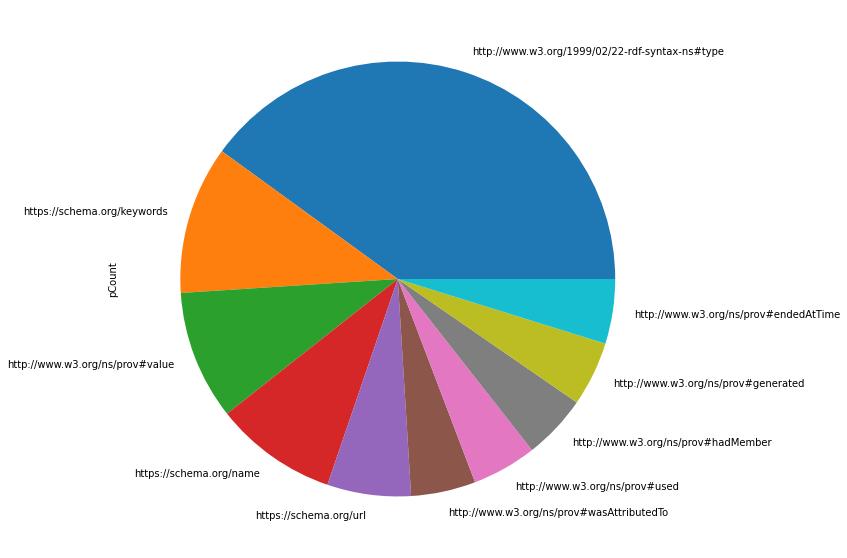

In [9]:
plot = hs.plot.pie(y='pCount',x='p',legend=False, figsize=(10, 10))

### Named Graphs

This query is looking at the

* cioos
* development
* eurocean
* invemar
* kb
* queue
* staging


In [10]:
rq_gcount = """
SELECT DISTINCT ?g
WHERE
{
    GRAPH ?g { }
}
"""

dfg = get_sparql_dataframe(sparqlep, rq_gcount)
dfg.head

<bound method NDFrame.head of                                                         g
0                    urn:gleaner.oihqueue:orgs:benguelacc
1          urn:gleaner.oihqueue:orgs:caribbeanmarineatlas
2                 urn:gleaner.oihqueue:orgs:cioosatlantic
3                       urn:gleaner.oihqueue:orgs:emodnet
4                       urn:gleaner.oihqueue:orgs:inanodc
...                                                   ...
217576  urn:gleaner.oih:obis:ffcbeeb41cdf480264e23c02a...
217577  urn:gleaner.oih:obis:ffd4f132186e8109ddf11a2e9...
217578  urn:gleaner.oih:obis:ffe6496dc8221b5e54b7e7fb5...
217579  urn:gleaner.oih:obis:fff9cf1ff5835933fb5bab8bf...
217580  urn:gleaner.oih:edmo:d33ca9d491e990c0706366191...

[217581 rows x 1 columns]>

In [11]:
# Make a new column based on the first 4 elements in the graph column
# Then group count that columns

dfg['gbase'] = dfg.apply(lambda row: row.g.rsplit(':', 1)[0], axis=1)
dfg['gbase'].value_counts()
# dfg['pCount'] = dfg["pCount"].astype(int) # convert count to int
# dfc.set_index('p', inplace=True)
# dfg_sorted = dfg.sort_values('pCount', ascending=False)
# dfg_sorted.head(10)



urn:gleaner.oih:prov:edmo                      165435
urn:gleaner-wf:prov:edmo                         9382
urn:gleaner-wf:prov:edmerp                       6833
urn:gleaner.oih:edmo                             4723
urn:gleaner-wf:summoned:edmo                     4691
urn:gleaner.oih:summoned:obis                    4680
urn:gleaner.oih:summoned:edmo                    4651
urn:gleaner.oih:obis                             4580
urn:gleaner.oih:edmerp                           3427
urn:gleaner-wf:summoned:edmerp                   3420
urn:gleaner.oih:summoned:edmerp                  3401
urn:gleaner-wf:prov:marinetraining                888
urn:gleaner.oih:marinetraining                    447
urn:gleaner.oih:summoned:marinetraining           444
urn:gleaner-wf:summoned:marinetraining            444
urn:gleaner.oih:prov:aquadocs                      48
urn:gleaner.oih:summoned:nodcid                    33
urn:gleaner-wf:orgs                                18
urn:gleaner.oihqueue:orgs   

In [12]:
rq_gcount = """
SELECT DISTINCT ?g
WHERE
{
    GRAPH ?g {?s ?p ?o} FILTER regex(str(?g), "^urn:gleaner:orgs")
}
"""

dfg = get_sparql_dataframe(sparqlep, rq_gcount)
# dfg['pCount'] = dfg["pCount"].astype(int) # convert count to int
# dfc.set_index('p', inplace=True)
# dfg_sorted = dfg.sort_values('pCount', ascending=False)
# dfg_sorted.head(10)

dfg.head

HTTPError: HTTP Error 504: Gateway Time-out

### OIH Base Query

In [25]:
rq_main = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?g  ?s   ?type ?score ?name ?url ?lit ?description ?headline
        WHERE
        {
           ?lit bds:search "coral" .
           ?lit bds:matchAllTerms "false" .
           ?lit bds:relevance ?score .
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }

        }
        ORDER BY DESC(?score)
        LIMIT 30
        OFFSET 0
        """

In [26]:
df = get_sparql_dataframe(sparqlep, rq_main)
df.head(5)

,g,s,type,score,name,url,lit,description,headline
0,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/16631,https://schema.org/CreativeWork,1.0,Estudio preliminar del fitoplancton y la estru...,https://www.oceandocs.org/handle/1834/16631,Coral.,- Se presenta el estudio preliminar del fitop...,None
1,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/16631,https://schema.org/CreativeWork,1.0,Estudio preliminar del fitoplancton y la estru...,https://www.oceandocs.org/handle/1834/16631,Coral.,- Se presenta el estudio preliminar del fitop...,None
2,urn:gleaner.oih:summoned:aquadocs:5e2a97ba3448...,oai:aquadocs.org:1834/16631,https://schema.org/CreativeWork,1.0,Estudio preliminar del fitoplancton y la estru...,https://www.oceandocs.org/handle/1834/16631,Coral.,- Se presenta el estudio preliminar del fitop...,None
3,urn:gleaner.oih:summoned:aquadocs:5e2a97ba3448...,oai:aquadocs.org:1834/25760,https://schema.org/CreativeWork,1.0,How to analyze fish community responses to cor...,https://www.oceandocs.org/handle/1834/25760,Coral,- Ways of evaluating the effects of environme...,None
4,urn:gleaner.oih:summoned:aquadocs:5e2a97ba3448...,oai:aquadocs.org:1834/4641,https://schema.org/CreativeWork,1.0,"Biodiversidad de corales, gorgonias y esponjas...",https://www.oceandocs.org/handle/1834/4641,Coral,- La investigaciÃ³n se realizÃ³ en los meses ...,None


### OIH Gleaner Query

In [27]:
rq_maingl = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?g  ?s  ?wat ?orgname ?domain ?type ?score ?name ?url ?lit ?description ?headline
        WHERE
        {
           ?lit bds:search "coral" .
           ?lit bds:matchAllTerms "false" .
           ?lit bds:relevance ?score .
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        ORDER BY DESC(?score)
        LIMIT 30
        OFFSET 0
        """

In [28]:
df = get_sparql_dataframe(sparqlep, rq_maingl)
df.head(5)

,g,s,wat,orgname,domain,type,score,name,url,lit,description,headline
0,urn:gleaner.oih:milled:obis:4e473923c875ed7bbd...,t1811501,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/66f21b70-3a41-4e6d-b3...,coral,The purpose of the Coral Reef Evaluation and M...,None
1,urn:gleaner.oih:milled:obis:51c1b6cb0a8dd0f7d7...,t1811927,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project D...,https://obis.org/dataset/a90912f8-33de-4725-80...,coral,The purpose of the Coral Reef Evaluation and M...,None
2,urn:gleaner.oih:milled:obis:5303691816051c7c8c...,t1812051,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/aaacf13e-a138-4b75-ba...,coral,The purpose of the Coral Reef Evaluation and M...,None
3,urn:gleaner.oih:milled:obis:58a90ddb672159cd87...,t1812697,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/320bc4a4-e0ee-493b-b4...,coral,The purpose of the Coral Reef Evaluation and M...,None
4,urn:gleaner.oih:milled:obis:5a824c072df459f20f...,t1812883,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project D...,https://obis.org/dataset/ef941346-7846-48fb-bf...,coral,The purpose of the Coral Reef Evaluation and M...,None


## Query for prov

Count (count(distinct ?tag) as ?count) 

Need to look for the date in the prov record too.  I keep it by day granularity, so I should be able to see the difference if I focos on a specific repo or look over the dates

In [10]:
rq_prov = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT   ( COUNT(?hm) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?wat ?orgname ?domain
        """

In [11]:
rq_prov2 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT ( COUNT(?s) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           graph ?g {
             VALUES (?type) { ( schema:CreativeWork ) ( schema:Map )  ( schema:Person )  ( schema:Organization )  ( schema:Dataset )  ( schema:Course ) } 
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
                GROUP BY ?wat ?orgname ?domain

        """

In [12]:
dfp = get_sparql_dataframe(sparqlep, rq_prov)
dfp['count'] = dfp["count"].astype(int) # convert count c to int
dfp.set_index('orgname', inplace=True)
dfp

,count,wat,domain
orgname,,,
Marine Training EU,445,https://www.re3data.org/repository/marinetraining,https://marinetraining.eu/
AquaDocs,1,https://www.re3data.org/repository/aquadocs,https://aquadocs.org
Ocean Biodiversity Information System,4877,https://www.re3data.org/repository/obis,https://obis.org
OceanExpert UNESCO/IOC Project Office for IODE,31294,https://www.re3data.org/repository/oceanexpert,https://oceanexpert.org/
Ocean Best Practices,1,https://www.re3data.org/repository/obps,https://oih.oceanbestpractices.org
EDMO SeaDataNet,4592,https://www.re3data.org/repository/seadatanet/...,https://edmo.seadatanet.org
EDMERP SeaDataNet,3397,https://www.re3data.org/repository/seadatanet/...,https://edmerp.seadatanet.org
EurOcean Events,2951,http://example.org/eurocean/events,https://infohub.eurocean.net/data/events
INVEMAR documents,1,http://example.org/invemar/documents,http://portete.invemar.org.co/chm/api/oih/docu...


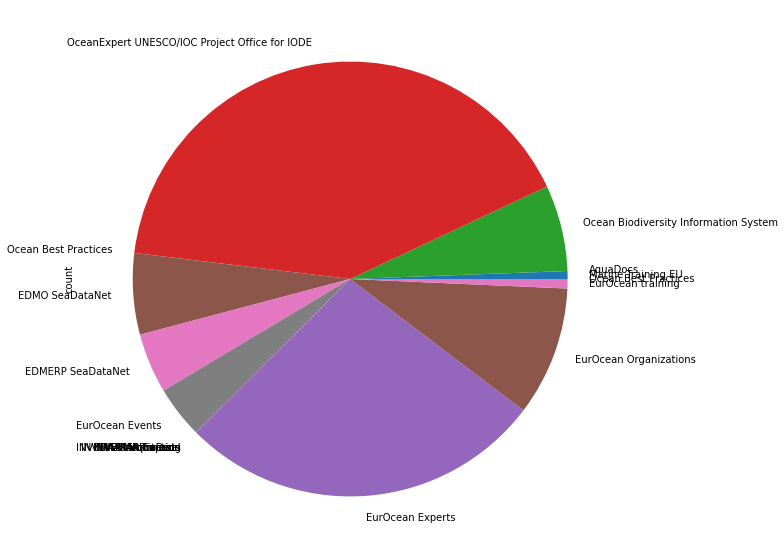

In [13]:
plot = dfp.plot.pie(y='count',legend=False, figsize=(10, 10))

In [14]:
rq_provdate = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?s) as ?count) ?time ?orgname
        WHERE
        {
           ?s a prov:Activity  .
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?time ?orgname  
        """

dfpd = get_sparql_dataframe(sparqlep, rq_provdate)

In [15]:
dfpd.head(30)

,count,time,orgname
0,938,2021-09-25T00:00:00.000Z,Marine Training EU
1,938,2021-10-18T00:00:00.000Z,Marine Training EU
2,936,2021-11-23T00:00:00.000Z,Marine Training EU
3,1067,2022-06-25T00:00:00.000Z,Marine Training EU
4,1068,2022-08-10T00:00:00.000Z,Marine Training EU
5,1068,2022-08-11T00:00:00.000Z,Marine Training EU
6,1068,2022-08-12T00:00:00.000Z,Marine Training EU
7,1068,2022-08-13T00:00:00.000Z,Marine Training EU
8,1068,2022-08-14T00:00:00.000Z,Marine Training EU
9,1068,2022-08-15T00:00:00.000Z,Marine Training EU


In [16]:
dfpd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   count    149 non-null    object
 1   time     149 non-null    object
 2   orgname  149 non-null    object
dtypes: object(3)
memory usage: 3.6+ KB


In [17]:
# dfpd = get_sparql_dataframe(oihdev, rq_provdate)
dfpd['count'] = dfpd["count"].astype(int) # convert count c to int
dfpd['time'] = pd.to_datetime(dfpd['time'])
dftime = dfpd.sort_values(by='time') 
# dfpd['time'] = dfpd['time'].astype('datetime64[ns]')
# dfpd.set_index('time', inplace=True)


In [18]:
dftime.set_index('time', inplace=True)

dftime.head(20)


,count,orgname
time,,
2021-09-25 00:00:00+00:00,938,Marine Training EU
2021-09-25 00:00:00+00:00,2,Ocean Best Practices
2021-09-25 00:00:00+00:00,82600,OceanExpert UNESCO/IOC Project Office for IODE
2021-09-25 00:00:00+00:00,7527,Ocean Biodiversity Information System
2021-09-25 00:00:00+00:00,1511,EurOcean training
2021-09-25 00:00:00+00:00,8016,EurOcean Events
2021-09-25 00:00:00+00:00,19328,EurOcean Organizations
2021-09-25 00:00:00+00:00,54622,EurOcean Experts
2021-09-25 00:00:00+00:00,2,AquaDocs


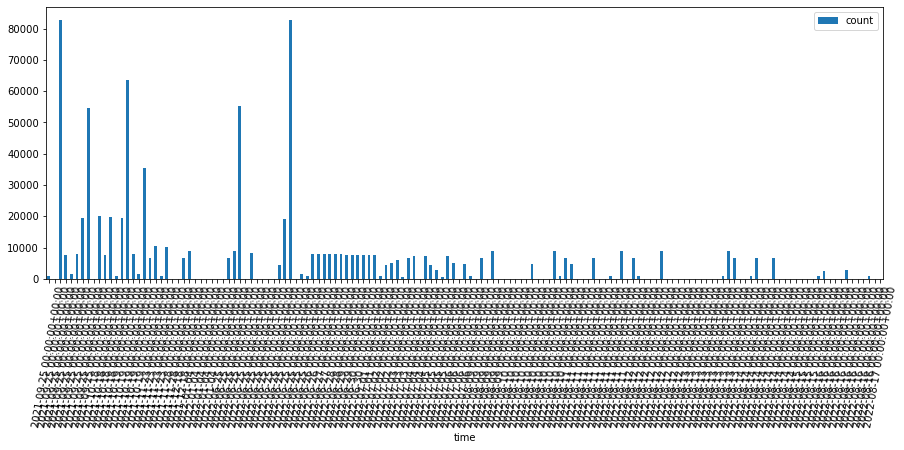

In [19]:
ax = dftime.plot.bar(rot=80, stacked=True, figsize=(15, 5))

## Feed query

Goal here is see if the prov will give us the elements for an RSS feed.  
The [RSS specs](https://validator.w3.org/feed/docs/rss2.html) give us the elements we need to populate.  Focus on; title(name), date, author, description

A recent example from gov at https://www.govinfo.gov/feeds

Since this could be very large injest, do it by the ingest events above instead?

* Element 	Description 	Example
* title 	The title of the item. 	Venice Film Festival Tries to Quit Sinking
* link 	The URL of the item. 	http://www.nytimes.com/2002/09/07/movies/07FEST.html
* description 	The item synopsis. 	Some of the most heated chatter at the Venice Film Festival this week was about the way that the arrival of the stars at the Palazzo del Cinema was being staged.
* author 	Email address of the author of the item. More. 	oprah@oxygen.net
* category 	Includes the item in one or more categories. More. 	Simpsons Characters
* comments 	URL of a page for comments relating to the item. More. 	http://www.myblog.org/cgi-local/mt/mt-comments.cgi?entry_id=290
* enclosure 	Describes a media object that is attached to the item. More. 	<enclosure url="http://live.curry.com/mp3/celebritySCms.mp3" length="1069871" type="audio/mpeg"/>
* guid 	A string that uniquely identifies the item. More. 	<guid isPermaLink="true">http://inessential.com/2002/09/01.php#a2</guid>
* pubDate 	Indicates when the item was published. More. 	Sun, 19 May 2002 15:21:36 GMT
* source 	The RSS channel that the item came from. More. 	<source url="http://www.quotationspage.com/data/qotd.rss">Quotes of the Day</source>

In [39]:
rq_provdatelist = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT  ?time ?orgname ?memval  ?memname ?memdesc
        WHERE
        {
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:value ?memval .
           ?mem schema:name ?memname .
           ?mem schema:description ?memdesc .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
        }
        ORDER BY DESC(?time) ASC(?memname)
        LIMIT 1000

        """

         #            ?s a prov:Activity  .

         #   ?wat rdfs:seeAlso ?domain

In [40]:
%%time
dfpl = get_sparql_dataframe(sparqlep, rq_provdatelist)
dfpl.head(10)

CPU times: user 11.3 ms, sys: 2.16 ms, total: 13.4 ms
Wall time: 8.1 s


,time,orgname,memval,memname,memdesc
0,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11405,'Akvanavt-98',Study of the hydro-physical characteristics of...
1,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11406,'Akvanavt-98-RF',Study of the hydrologic structure in Russian s...
2,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11410,'Akvanavt-99-m',Method preparation and experimental works on s...
3,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11407,'Djubga',Study of the seismic and seismic-acoustic bott...
4,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11414,'Integrated optical-hydro-lithodynamics inves...,Integrated optical-hydro-lithodynamics investi...
5,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11408,'Neftyanik',Carrying out of the hydrographical survey by t...
6,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11415,'Turbidimetr -2000',"Research, development and making of the suspen..."
7,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11273,(CIPS/ICWB) SEA - an extensive multidisciplina...,"ï¿½Project Sea"" was the first major programme ..."
8,2021-12-18T00:00:00.000Z,EDMO SeaDataNet,https://edmo.seadatanet.org/report/4141,(Inland Fisheries Ireland) Cullion Fish Farm,Inland Fisheries Ireland trout fish farm opera...
9,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/10405,18 EXPEDITION 'ASSESSMENT OF CONTAMINATION OF ...,Aims of the expedition included also carrying ...


## Keywords

In [41]:
rq_keywords = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT   ( COUNT(?kw) as ?count) ?kw   
        WHERE
        {
           ?s schema:keywords ?kw
        }
        GROUP BY ?kw  
        ORDER BY DESC(?count)
        """


In [42]:
dfkw = get_sparql_dataframe(sparqlep, rq_keywords)
dfkw['count'] = dfkw["count"].astype(int) # convert count c to int
dfkw.set_index('kw', inplace=True)
dfkw.head(10)

,count
kw,
Fisheries,43873
Biology,20834
Aquaculture,11790
Ecology,10524
GCFI,8856
Iran,8382
Management,7809
Occurrence,6825
Observation,5317


In [43]:
dfkw.to_csv('keywords.csv', index=False)

In [44]:
rq_typesCHECK = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT  ( COUNT(?type) as ?count) ?type   
        WHERE
         {
           graph ?g {
            
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
          
        }
        GROUP BY ?type  
         ORDER BY DESC(?count)
   
        """

#      GROUP BY ?type  
#         ORDER BY DESC(?count)

#  ( COUNT(?type) as ?count) ?type  

# ?s ?p ?lit .

#  ?wat rdf:name "Ocean Biodiversity Information System" .

In [45]:
dft = get_sparql_dataframe(sparqlep, rq_typesCHECK)
# dft['count'] = dft["count"].astype(int) # convert count c to int
# dft.set_index('type', inplace=True)
dft.head(20)

,count,type
0,289746,https://schema.org/Person
1,145419,https://schema.org/Text
2,91390,https://schema.org/PropertyValue
3,81390,https://schema.org/CreativeWork
4,81386,https://schema.org/ListItem
5,76040,https://schema.org/Organization
6,40427,https://schema.org/Event
7,27696,https://schema.org/Country
8,18783,https://schema.org/PostalAddress
9,17796,https://schema.org/Place


## Check status of spatial predicates

We have 3500+ items with spatial data using the scheme.org vocabulary.   No current data published using the geosparql WKT patterns.  

In [46]:
rq_wktcount = """SELECT (COUNT(?s) as ?sCount)
WHERE
{
  {
  ?s <http://www.opengis.net/ont/geosparql#hasGeometry> ?o .
}
UNION
{
  ?s <https://schema.org/spatialCoverage> ?o
  }
}
"""

In [47]:
dfwc = get_sparql_dataframe(sparqlep, rq_wktcount)
dfwc['sCount'] = dfwc["sCount"].astype(int) # convert count to int
# dfc.set_index('p', inplace=True)

In [48]:
dfwc.head()

,sCount
0,7363


In [49]:
rq_dups = """
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?name) as ?count) ?name   
        WHERE
        {
          ?s rdf:type ?type
           FILTER ( ?type IN ( schema:Dataset, schema:CreativeWork) )
           ?s schema:name ?name

        }
        GROUP BY ?name  
        HAVING (?count > 1)
        ORDER BY DESC(?count)
        """


dfdp = get_sparql_dataframe(sparqlep, rq_dups)
dfdp['count'] = dfdp["count"].astype(int) # convert count c to int
dfdp.set_index('name', inplace=True)
dfdp.info()
dfdp.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 6551 entries,  to Resource collection for https://CHM-LAC/
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   6551 non-null   int64
dtypes: int64(1)
memory usage: 102.4+ KB


,count
name,
,381
News from Academy Bay,22
"Roundup: news, events, briefings and more",10
Introduction,9
Determination of effective parameters on growth and bloom forming of Cochlodinium polykrikoides,5
"Discussion, biological session",5
"Effects of aflatoxin B1 on growth performance, health indices, phagocytic activity and histopathological alteration in Fenneropenaeus indicus",4
"Isolation, identification and phylogenetic analysis of a pathogen of Haliotis diversicolor supertexta (L.) with mass mortalities",4
Study of possibilities of aquaculture activities in the Gorgan Bay,4


In [50]:
qex1 = """PREFIX prov: <http://www.w3.org/ns/prov#> .
PREFIX con: <http://www.ontotext.com/connectors/lucene#> .
PREFIX luc: <http://www.ontotext.com/owlim/lucene#> .
PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#> .
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
PREFIX schema: <https://schema.org/> .
PREFIX schemaold: <http://schema.org/> .
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

SELECT DISTINCT ?s  ?name  
WHERE
        {
           ?lit bds:search "A General formatting system for geo-referenced data" .
           ?lit bds:matchAllTerms "false" .

           graph ?g {
            ?s ?p ?lit .
            FILTER isIRI(?s)
             OPTIONAL { ?s schema:name ?name .   }
           }
        }
GROUP BY    ?name ?s
LIMIT 300
OFFSET 0
"""

## OIH Query "lens"

Exploring how sites like http://portete.invemar.org.co/chm#/table could leverage OIH. Searches like "acidification"  A popular return for that search is https://aquadocs.org/handle/1834/9819 which is found in the OIH graph via [this search](https://oceans.collaborium.io/?search=Optimizaci%C3%B3n+de+los+procesos+de+ensilado+a+partir+de+residuos+de+la+industria+pesquera+y+evaluaci%C3%B3n+de+nuevas+aplicaciones+en+la+alimentaci%C3%B3n+animal.).

The thought is what would a search site do via the OIH graph that might be interesting.  We can think about looking for the types associated with a result and then seeing what the next level result would be.   



In [51]:
lens1 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT  ?t ?ttype ?name
        WHERE

        {
           ?s ?p "https://www.oceandocs.org/handle/1834/9819" .
           ?s ?pp ?t .
           ?t a ?ttype .
           ?t schema:name ?name
  
  }
  """

dflens1 = get_sparql_dataframe(sparqlep, lens1)
dflens1.head(10)

,t,ttype,name
0,t231465,https://schema.org/Organization,Universidad Nacional del Comahue. Centro Regio...
1,t366674,https://schema.org/Person,"GÃ³ngora, HernÃ¡n G."


In [52]:
lens2 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT  ?us ?up ?ao ?uus ?uup
        WHERE

        {
           ?s ?p "https://www.oceandocs.org/handle/1834/9819" .
              ?s <https://schema.org/author> ?auth .
              ?auth <https://schema.org/name> ?ao .
 
              ?us ?up ?ao .
              ?uus ?uo ?us
  
  }
  """

dflens1 = get_sparql_dataframe(sparqlep, lens2)
dflens1.head(10)

,us,up,ao,uus,uup
0,t366674,https://schema.org/name,"GÃ³ngora, HernÃ¡n G.",oai:aquadocs.org:1834/9819,None


In [53]:
lens3 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT ?itemp ?itemo
        WHERE
        {
        
           ?s rdf:type 	<https://schema.org/Vehicle> .
            ?s 	<https://schema.org/itemListElement> ?le .
                ?le ?lep ?item .
           ?item ?itemp ?itemo
        }
 
  """

dflens1 = get_sparql_dataframe(sparqlep, lens3)
dflens1.head(10)

,itemp,itemo
0,https://schema.org/category,Regional
1,https://schema.org/vehicleConfiguration,Sensores Thales SMART-S Mk-2. Multifunction ra...
2,https://schema.org/vehicleSpecialUsage,Defense
3,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,https://schema.org/Vehicle
4,https://schema.org/description,Buque oceanogrÃ¡fico de la Armada de Venezuela...
5,https://schema.org/name,ARBV Punta Brava (BO-11)
6,https://schema.org/url,
7,https://schema.org/category,Regional
8,https://schema.org/vehicleConfiguration,Radar de NavegaciÃ³n Principal y Radar de Nave...
9,https://schema.org/vehicleSpecialUsage,Oceanography


## Monitoring and Indicator

### PI 1  Number of content items shared though the system by type

In [54]:
rq_types = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>


       SELECT   ( COUNT(?type) as ?count) ?type
        WHERE
        {

           ?s rdf:type ?type
           FILTER ( ?type IN (schema:ResearchProject, schema:Project, schema:Organization, schema:Dataset, schema:CreativeWork, schema:Person, schema:Map, schema:Course, schema:CourseInstance, schema:Event, schema:Vehicle) )

        }
        GROUP BY ?type
        ORDER BY DESC(?count)
        """

dft = get_sparql_dataframe(sparqlep, rq_types)
dft['count'] = dft["count"].astype(int) # convert count c to int
dft.set_index('type', inplace=True)
dft.head(10)

,count
type,
https://schema.org/Person,345127
https://schema.org/Organization,87007
https://schema.org/CreativeWork,41058
https://schema.org/Event,40393
https://schema.org/Dataset,8509
https://schema.org/ResearchProject,3354
https://schema.org/CourseInstance,1651
https://schema.org/Course,1282
https://schema.org/Vehicle,85


### PI 1. Number of ODIS integrated products/services developed

Need a query that extracts individual sources, not just institutions.
So for example INVEMAR have 5 source URLs that should only count as 1.

It is claimed that "2.Integration of ODIS products/services into Ocean InfoHub" is the
same as this query.

There was a request for "number of partners indexed" and it's not clear how this is
different than this query?

_product/service vs nodes_ needs to be defined.
seadata is a node..  it has 2 services

Sheet Row 7: Number of ODIS integrated products/services developed:  12  (all URIs contributin to graph

Sheet Row 10: Integration of ODIS products/services into Ocean InfoHub:  Need clarification  (same as row 7 at this stage)

Show Row 12: PI 1. Number of nodes participating in the Ocean InfoHub:  Row 7 removing duplications from same provider  (ie, INVEMAR's 5 URIs become 1 proivider here)

Are row 21 and 12 the same thing?  If not what is the difference  (they are same)



In [55]:
rq_prov = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT   ( COUNT(?hm) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?wat ?orgname ?domain
        """

dfp = get_sparql_dataframe(sparqlep, rq_prov)
dfp['count'] = dfp["count"].astype(int) # convert count c to int
dfp.set_index('orgname', inplace=True)
dfp

,count,wat,domain
orgname,,,
AquaDocs,1,https://www.re3data.org/repository/aquadocs,https://aquadocs.org
Marine Training EU,313,https://www.re3data.org/repository/marinetraining,https://marinetraining.eu/
Ocean Biodiversity Information System,4382,https://www.re3data.org/repository/obis,https://obis.org
OceanExpert UNESCO/IOC Project Office for IODE,29103,https://www.re3data.org/repository/oceanexpert,https://oceanexpert.org/
Ocean Best Practices,1,https://www.re3data.org/repository/obps,https://oih.oceanbestpractices.org
EDMO SeaDataNet,4508,https://www.re3data.org/repository/seadatanet/...,https://edmo.seadatanet.org
EDMERP SeaDataNet,3354,https://www.re3data.org/repository/seadatanet/...,https://edmerp.seadatanet.org
INVEMAR documents,1,http://example.org/invemar/documents,http://portete.invemar.org.co/chm/api/oih/docu...
INVEMAR Experts,1,http://example.org/invemar/experts,http://portete.invemar.org.co/chm/api/oih/expert
